In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import ViTModel, ViTConfig
from PIL import Image
from io import BytesIO
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = 'food101/data'
BATCH_SIZE = 32
NUM_WORKERS = 0
NUM_CLASSES = 101
MAX_PER_CLASS = 300
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset and dataloader

In [3]:
class FoodDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform = None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        rec = self.df.iloc[index]
        img = Image.open(BytesIO(rec['image']['bytes'])).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, int(rec['label'])
def load_and_sample(prefix: str):
    files = sorted(f for f in os.listdir(DATA_DIR) if f.startswith(prefix))
    df = pd.concat([pd.read_parquet(os.path.join(DATA_DIR, f)) for f in files], ignore_index=True)
    df = df.groupby('label', group_keys=False).apply(
        lambda x: x.sample(n=min(len(x), MAX_PER_CLASS), random_state=42)
    ).reset_index(drop=True)
    return df

def get_dataloaders(image_size):
    train_df = load_and_sample('train-')
    val_df = load_and_sample('validation-')
    train_tf = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3),
    ])
    val_tf = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3),
    ])
    train_dl = DataLoader(FoodDataset(train_df, train_tf), batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    val_dl = DataLoader(FoodDataset(val_df, val_tf), batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    return train_dl, val_dl

Build model, freezing and unfreezing

In [ ]:
def build_model(dropout, label_smooth, unfreeze_layers):
    backbone = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
    if unfreeze_layers == 0:
        for p in backbone.parameters():
            p.requires_grad = False
    else:
        for p in backbone.parameters():
            p.requires_grad = False
            layers = backbone.encoder.layer
            for layer in layers[-unfreeze_layers:]:
                for p in layer.parameters():
                    p.requires_grad=True
    hidden = backbone.config.hidden_size
    classifier = nn.Sequential(
        nn.Linear(hidden, 512),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(128, NUM_CLASSES),
    )

    class VitForFood(nn.Module):
        def __init__(self, backbone, classifier, label_smooth):
            super().__init__()
            self.backbone = backbone
            self.classifier = classifier
            self.criterion = nn.CrossEntropyLoss(label_smoothing=label_smooth)
        
        def forward(self, x, labels = None):
            out = self.backbone(pixel_values = x)
            pooled = out.pooler_output
            logits = self.classifier(pooled)
            loss = None
            if labels is not None:
                loss = self.criterion(logits, labels)
            return logits, loss
        
    return VitForFood(backbone, classifier, label_smooth)

train and validation

In [5]:
def train_model(model, traindl, valdl, epochs, lr, es_patience, reduce_patience, reduce_factor, minlr, stage_name):
    model.to(DEVICE)
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=reduce_factor, patience=reduce_patience, min_lr=minlr, verbose=True)
    best_val = float('inf')
    wait = 0
    train_losses, val_losses = [],[]
    last_preds,last_labels = [],[]
    for ep in range(1,epochs+1):
        #train
        model.train()
        tot_train = 0
        for imgs, labels in tqdm(traindl, desc = f"{stage_name} Ep{ep}/{epochs} Train"):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            logits, loss = model(imgs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tot_train += loss.item()
        avg_train = tot_train / len(traindl)
        train_losses.append(avg_train)

        #validation
        model.eval()
        tot_val, preds, labs = 0, [], []
        with torch.no_grad():
            for imgs, labels in tqdm(valdl, desc = f"{stage_name} Ep{ep}/{epochs} Val"):
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                logits, loss = model(imgs, labels)
                tot_val += loss.item()
                preds.extend(logits.argmax(dim=1).cpu().tolist())
                labs.extend(labels.cpu().tolist())
        avg_val = tot_val / len(valdl)
        val_losses.append(avg_val)

        print(f"{stage_name} Ep{ep}: Train loss = {avg_train:.4f},   Val loss = {avg_val:.4f}")
        scheduler.step(avg_val)
        #early stopping
        if avg_val < best_val:
            best_val = avg_val
            wait = 0
            torch.save(model.state_dict(), f"best_{stage_name}.pth")
            print(f"Saved best_{stage_name}.pth")
        else: 
            wait += 1
            if wait >= es_patience:
                print(f"Early stopping at epoch {ep}")
                break
        last_preds, last_labels = preds, labs
    return last_preds, last_labels, train_losses, val_losses

run main process

In [6]:
print('preparing data')
train_dl, val_dl = get_dataloaders(image_size=224)
print("\n===Stage 1: train head only ===")
model1 = build_model(dropout=0.5, label_smooth= 0.1, unfreeze_layers=0)
preds1, labels1, _, _ = train_model(
    model1, train_dl, val_dl,
    epochs=10, lr=1e-3,
    es_patience=5,
    reduce_factor=0.2, reduce_patience=2, minlr=1e-6,
    stage_name="stage1"
)
print("\n===Stage 2: fine tuning last half of backbone and head ===")
model2 = build_model(dropout=0.5, label_smooth=0.1, unfreeze_layers=6)

try:
    model2.load_state_dict(model1.state_dict())
    print("Stage 1 weights loaded into stage 2 model")
except Exception as e:
    print("Fail to load weight, starting Stage 2 from scratch:", e)

preds2, labels2, train_losses2, val_losses2 = train_model(
    model2, train_dl, val_dl,
    epochs=20, lr=5e-6,
    es_patience=5,
    reduce_factor=0.2, reduce_patience=3, minlr=1e-7,
    stage_name="stage2"
)

preparing data

===Stage 1: train head only ===


d:\anaconda\envs\nn_env\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
stage1 Ep1/10 Train:   0%|          | 0/947 [00:00<?, ?it/s]d:\anaconda\envs\nn_env\lib\site-packages\transformers\models\vit\modeling_vit.py:277: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(
stage1 Ep1/10 Val: 100%|██████████| 790/790 [04:35<00:00,  2.87it/s]


stage1 Ep1: Train loss = 2.8101,   Val loss = 1.6749
Saved best_stage1.pth


stage1 Ep2/10 Val: 100%|██████████| 790/790 [04:33<00:00,  2.88it/s]


stage1 Ep2: Train loss = 2.1730,   Val loss = 1.5722
Saved best_stage1.pth


stage1 Ep3/10 Val: 100%|██████████| 790/790 [04:35<00:00,  2.87it/s]


stage1 Ep3: Train loss = 2.0773,   Val loss = 1.5345
Saved best_stage1.pth


stage1 Ep4/10 Val: 100%|██████████| 790/790 [04:34<00:00,  2.88it/s]


stage1 Ep4: Train loss = 2.0256,   Val loss = 1.5016
Saved best_stage1.pth


stage1 Ep5/10 Val: 100%|██████████| 790/790 [04:34<00:00,  2.88it/s]


stage1 Ep5: Train loss = 1.9961,   Val loss = 1.4955
Saved best_stage1.pth


stage1 Ep6/10 Val: 100%|██████████| 790/790 [04:33<00:00,  2.89it/s]


stage1 Ep6: Train loss = 1.9679,   Val loss = 1.4944
Saved best_stage1.pth


stage1 Ep7/10 Val: 100%|██████████| 790/790 [04:33<00:00,  2.89it/s]


stage1 Ep7: Train loss = 1.9426,   Val loss = 1.4743
Saved best_stage1.pth


stage1 Ep8/10 Val: 100%|██████████| 790/790 [04:33<00:00,  2.89it/s]


stage1 Ep8: Train loss = 1.9277,   Val loss = 1.4636
Saved best_stage1.pth


stage1 Ep9/10 Val: 100%|██████████| 790/790 [04:33<00:00,  2.89it/s]


stage1 Ep9: Train loss = 1.9070,   Val loss = 1.4565
Saved best_stage1.pth


stage1 Ep10/10 Val: 100%|██████████| 790/790 [04:34<00:00,  2.88it/s]


stage1 Ep10: Train loss = 1.8898,   Val loss = 1.4516
Saved best_stage1.pth

===Stage 2: fine tuning last half of backbone and head ===
Stage 1 weights loaded into stage 2 model


stage2 Ep1/20 Val: 100%|██████████| 790/790 [04:32<00:00,  2.90it/s]


stage2 Ep1: Train loss = 1.8093,   Val loss = 1.3996
Saved best_stage2.pth


stage2 Ep2/20 Val: 100%|██████████| 790/790 [04:33<00:00,  2.89it/s]


stage2 Ep2: Train loss = 1.7429,   Val loss = 1.3791
Saved best_stage2.pth


stage2 Ep3/20 Val: 100%|██████████| 790/790 [04:32<00:00,  2.90it/s]


stage2 Ep3: Train loss = 1.7135,   Val loss = 1.3666
Saved best_stage2.pth


stage2 Ep4/20 Val: 100%|██████████| 790/790 [04:34<00:00,  2.88it/s]


stage2 Ep4: Train loss = 1.6735,   Val loss = 1.3548
Saved best_stage2.pth


stage2 Ep5/20 Val: 100%|██████████| 790/790 [04:34<00:00,  2.88it/s]


stage2 Ep5: Train loss = 1.6467,   Val loss = 1.3489
Saved best_stage2.pth


stage2 Ep6/20 Val: 100%|██████████| 790/790 [04:49<00:00,  2.73it/s]


stage2 Ep6: Train loss = 1.6147,   Val loss = 1.3405
Saved best_stage2.pth


stage2 Ep7/20 Val: 100%|██████████| 790/790 [04:44<00:00,  2.78it/s]


stage2 Ep7: Train loss = 1.5960,   Val loss = 1.3349
Saved best_stage2.pth


stage2 Ep8/20 Val: 100%|██████████| 790/790 [04:33<00:00,  2.89it/s]


stage2 Ep8: Train loss = 1.5724,   Val loss = 1.3303
Saved best_stage2.pth


stage2 Ep9/20 Val: 100%|██████████| 790/790 [04:33<00:00,  2.89it/s]


stage2 Ep9: Train loss = 1.5504,   Val loss = 1.3256
Saved best_stage2.pth


stage2 Ep10/20 Val: 100%|██████████| 790/790 [04:33<00:00,  2.88it/s]


stage2 Ep10: Train loss = 1.5303,   Val loss = 1.3239
Saved best_stage2.pth


stage2 Ep11/20 Val: 100%|██████████| 790/790 [04:33<00:00,  2.89it/s]


stage2 Ep11: Train loss = 1.5163,   Val loss = 1.3191
Saved best_stage2.pth


stage2 Ep12/20 Val: 100%|██████████| 790/790 [04:34<00:00,  2.88it/s]


stage2 Ep12: Train loss = 1.4945,   Val loss = 1.3185
Saved best_stage2.pth


stage2 Ep13/20 Val: 100%|██████████| 790/790 [04:35<00:00,  2.87it/s]


stage2 Ep13: Train loss = 1.4778,   Val loss = 1.3127
Saved best_stage2.pth


stage2 Ep14/20 Val: 100%|██████████| 790/790 [04:32<00:00,  2.89it/s]


stage2 Ep14: Train loss = 1.4641,   Val loss = 1.3122
Saved best_stage2.pth


stage2 Ep15/20 Val: 100%|██████████| 790/790 [04:33<00:00,  2.89it/s]


stage2 Ep15: Train loss = 1.4440,   Val loss = 1.3095
Saved best_stage2.pth


stage2 Ep16/20 Val: 100%|██████████| 790/790 [04:32<00:00,  2.90it/s]


stage2 Ep16: Train loss = 1.4295,   Val loss = 1.3091
Saved best_stage2.pth


stage2 Ep17/20 Val: 100%|██████████| 790/790 [04:32<00:00,  2.89it/s]


stage2 Ep17: Train loss = 1.4190,   Val loss = 1.3067
Saved best_stage2.pth


stage2 Ep18/20 Val: 100%|██████████| 790/790 [04:33<00:00,  2.89it/s]


stage2 Ep18: Train loss = 1.4036,   Val loss = 1.3062
Saved best_stage2.pth


stage2 Ep19/20 Val: 100%|██████████| 790/790 [04:33<00:00,  2.89it/s]


stage2 Ep19: Train loss = 1.3937,   Val loss = 1.3036
Saved best_stage2.pth


stage2 Ep20/20 Val: 100%|██████████| 790/790 [04:32<00:00,  2.89it/s]


stage2 Ep20: Train loss = 1.3794,   Val loss = 1.3035
Saved best_stage2.pth


get result

=== Classification Report (Stage 2) ===
                         precision    recall  f1-score   support

              apple_pie     0.7336    0.6720    0.7015       250
         baby_back_ribs     0.8479    0.8920    0.8694       250
                baklava     0.8862    0.8720    0.8790       250
         beef_carpaccio     0.8721    0.9000    0.8858       250
           beef_tartare     0.7826    0.8640    0.8213       250
             beet_salad     0.7901    0.8280    0.8086       250
               beignets     0.9065    0.8920    0.8992       250
               bibimbap     0.9183    0.9440    0.9310       250
          bread_pudding     0.6584    0.7400    0.6968       250
      breakfast_burrito     0.8491    0.7880    0.8174       250
             bruschetta     0.8347    0.8080    0.8211       250
           caesar_salad     0.8969    0.9400    0.9180       250
                cannoli     0.9025    0.8520    0.8765       250
          caprese_salad     0.8528    0.9040    0

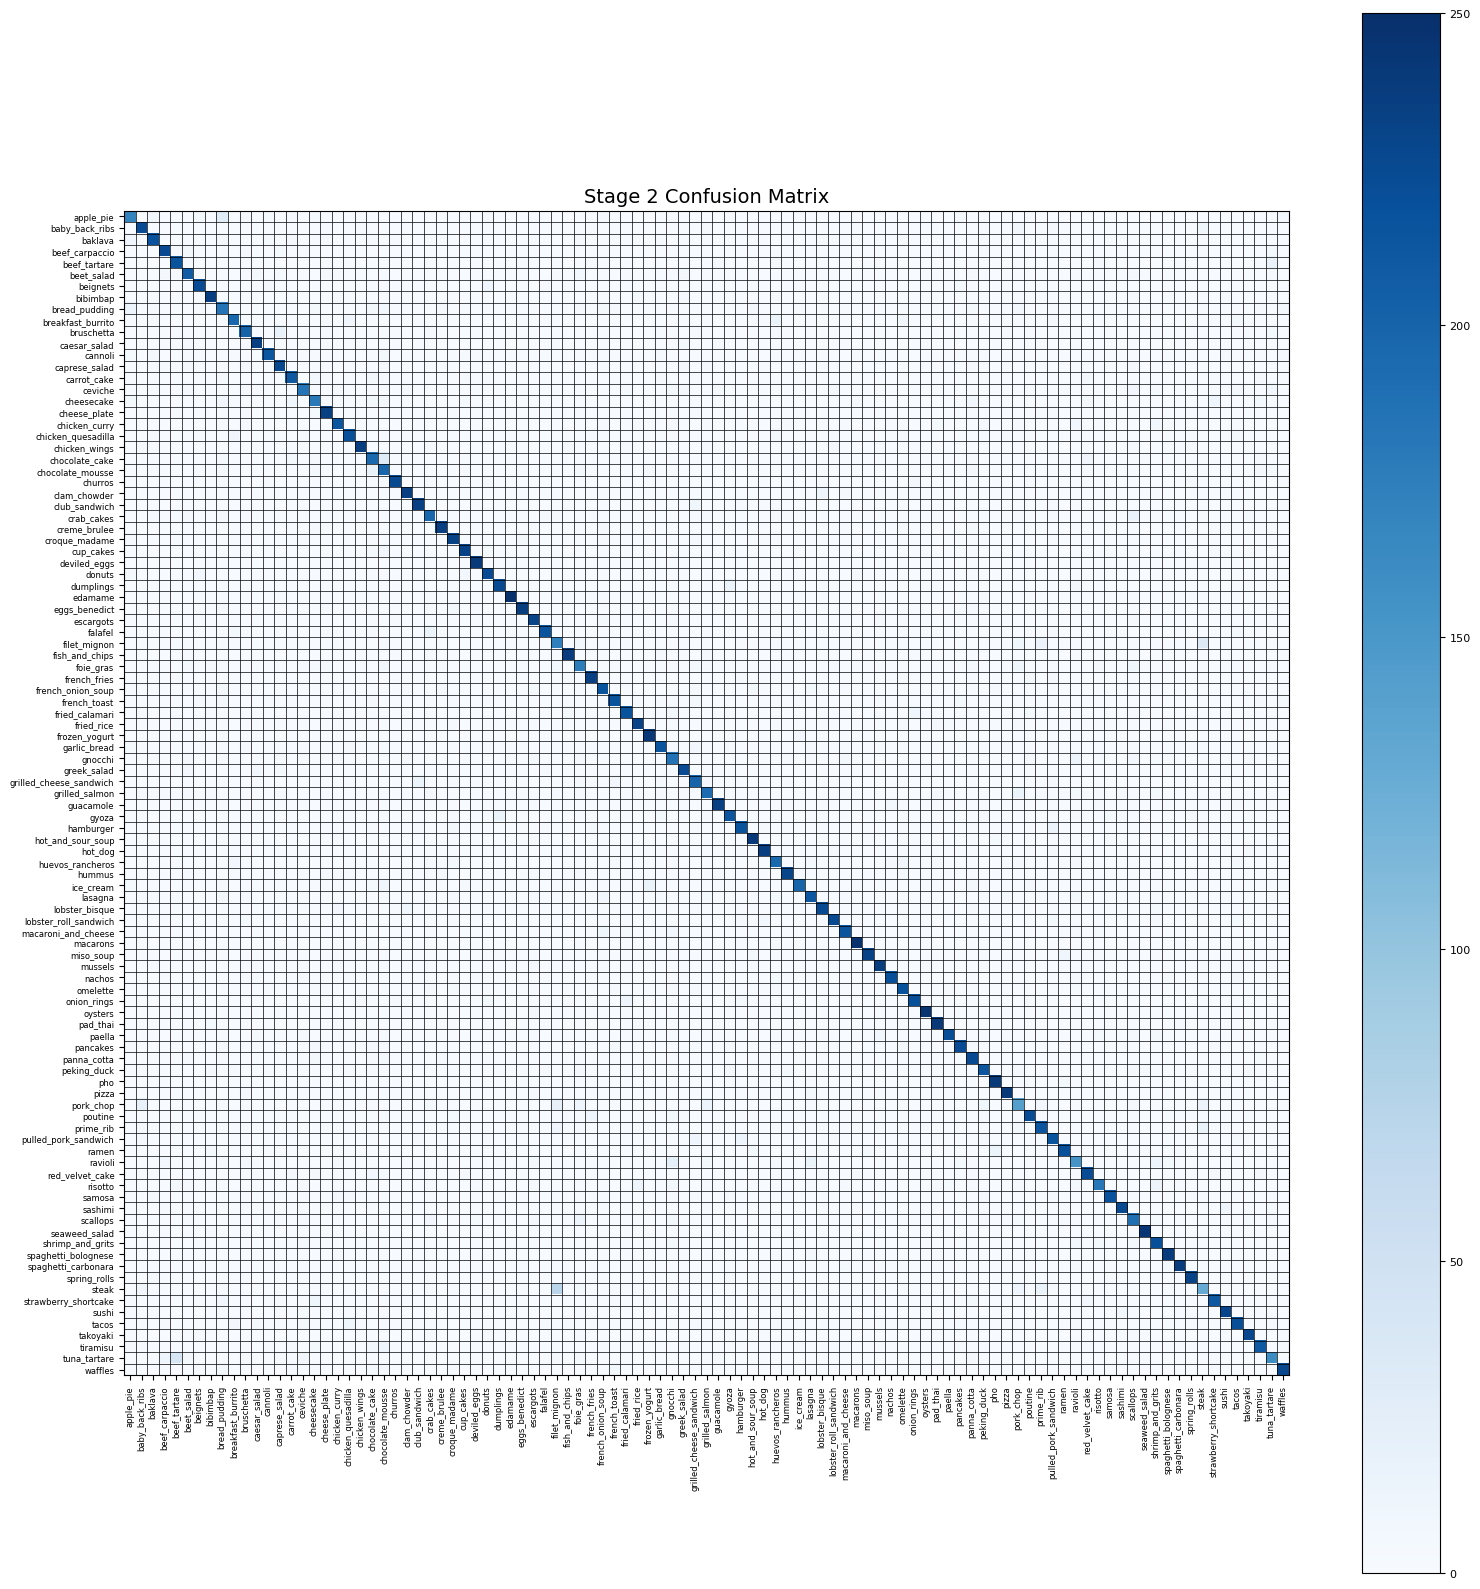

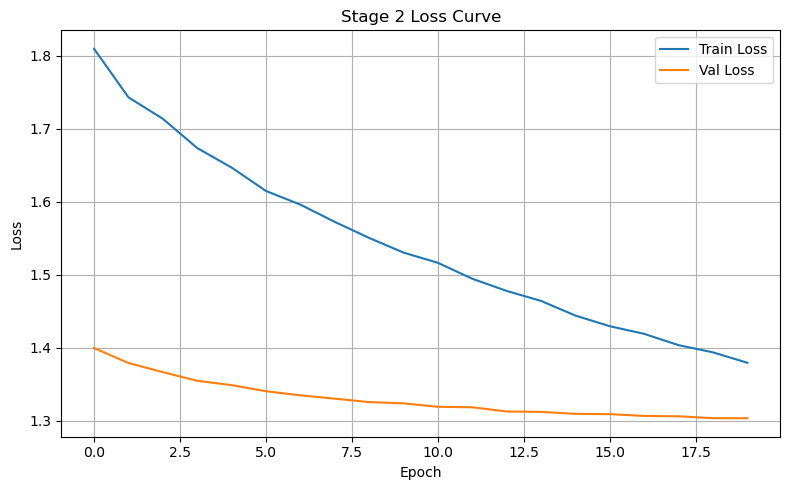

In [9]:
from datasets import load_dataset
import numpy as np
hf_ds = load_dataset("ethz/food101", split="train")      # 只下载元数据，不拉取图像
class_names = hf_ds.features["label"].names             # List[str]，长度 101

# 3. 打印 Classification Report
print("=== Classification Report (Stage 2) ===")
print(classification_report(labels2, preds2, target_names=class_names, digits=4))

# 4. 绘制 Confusion Matrix
cm = confusion_matrix(labels2, preds2)
fig, ax = plt.subplots(figsize=(16, 16))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

# 加 colorbar（可选）
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=8)

# 主刻度：放类别标签
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=90, fontsize=6)  # 根据需要调整 fontsize
ax.set_yticklabels(class_names, fontsize=6)

# 边框格子：在每个 cell 之间画细黑线
ax.set_xticks(np.arange(-.5, len(class_names), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(class_names), 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)
# 关闭 minor tick 本身的刻度线
ax.tick_params(which='minor', bottom=False, left=False)

# 标题
ax.set_title("Stage 2 Confusion Matrix", fontsize=14)
plt.tight_layout()
plt.show()

# 5. 绘制 Stage 2 Loss 曲线
plt.figure(figsize=(8,5))
plt.plot(train_losses2, label='Train Loss')
plt.plot(val_losses2,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Stage 2 Loss Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()